# Projet méthodes pour la science des données

# I. Chargement des données

In [1]:
import pandas as pd

df_dataset=pd.read_csv('Dataset/claimskg_result.csv')
df_original=df_dataset.copy()

# II. Informations sur le dataframe

In [2]:
shape=df_dataset.shape
print("Nombre d'enregistrements : ")
print(shape[0])
print("Nombre de colonnes : ")
print(shape[1])
print("Informations sur les colonnes")
df_dataset.info()

Nombre d'enregistrements : 
10000
Nombre de colonnes : 
14
Informations sur les colonnes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   id                      10000 non-null  object
 1   text                    10000 non-null  object
 2   date                    10000 non-null  object
 3   truthRating             10000 non-null  int64 
 4   ratingName              10000 non-null  object
 5   author                  10000 non-null  object
 6   headline                9882 non-null   object
 7   named_entities_claim    9864 non-null   object
 8   named_entities_article  6497 non-null   object
 9   keywords                8691 non-null   object
 10  source                  10000 non-null  object
 11  sourceURL               10000 non-null  object
 12  link                    10000 non-null  object
 13  language          

On observe qu'il n'existe qu'un seul champs dont le type des valeurs est numérique : truthRating qui indique si l'affirmation est vraie, fausse ou un mélange de vraies et de fausses informations. Les autres types correspondent tous à des chaîne de caractères.

Parmi les colonnes du Dataframe, certaines colonnes ne sont pas nécessaire pour les tâches de classification. On peut par exemple vérifier qu'il y'a une bijection entre l'ensemble des valeurs de truthRating et l'ensemble des valeurs de ratingName.

In [3]:
g=df_dataset.groupby(['truthRating', 'ratingName'])
print(g['id'].count())

truthRating  ratingName
-1           OTHER         1761
 1           FALSE         3665
 2           MIXTURE       3247
 3           TRUE          1327
Name: id, dtype: int64


La colonne language non plus n'est pas utile à l'apprentissage car tous les enregistrement dans le dataframe on la valeur 'English' pour cette colonne.

# III. Feature engeenering

## III.a. Valeurs manquantes

Ci-dessous sont présentés les nombres de chaînes de caractères vides par colonnes dans le dataframe.

headline : 118
named_entities_claim : 136
named_entities_article : 3503
keywords : 1309


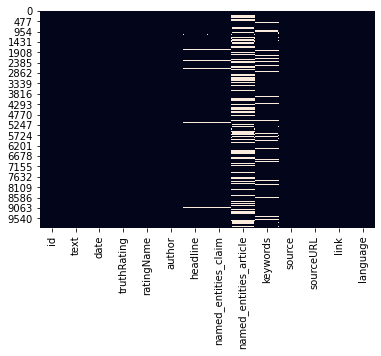

In [4]:
import seaborn as sns
sns.heatmap(df_dataset.isnull(), cbar=False)

def count_empty_values(df):
    columns=df_dataset.columns[df.isnull().any()].tolist()
    for column in columns:
        print(column + " : " + str(df[column].isnull().sum()))

count_empty_values(df_dataset)

On remarque que toutes ces colonnes de type 'chaîne de caractère', on ne peut donc pas effectuer de calcul de moyennes pour remplir les informations manquantes. Il n'est pas non plus envisageables de supprimer les enregistrements correspondant car les autres colonnes portent des informations utiles à l'apprentissages.

On s'intéresse maintenant aux enregistrements qui ne portent pas la classe cible des tâches d'apprentissage :

In [5]:
print("Enregistrements non FALSE, TRUE ou MIXTURE : " + str(df_dataset[df_dataset['truthRating'] == -1].count()['id']))

Enregistrements non FALSE, TRUE ou MIXTURE : 1761


Comme ces enregistrements ne peuvent servir pour l'apprentissage, on peut se permettre de les supprimer.

In [6]:
df_dataset = df_dataset[df_dataset['truthRating'] != -1]
df_dataset = df_dataset.reset_index(drop=True)

On peut constater l'impact sur les valeurs manquantes des quatres colonnes contenant des valeurs nulles :

In [7]:
count_empty_values(df_dataset)

named_entities_claim : 11
named_entities_article : 2966
keywords : 464


On compte maintenant le nombre de date dont la valeur est unknown dans le dataframe

In [8]:
print(df_dataset[df_dataset['date'] == 'Unknown'].count()['id'])

3422


Les date étant sous forme de chaîne de caractère, nous choisissons de les convertir en timestamp afin que les algorithmes de classification puisse trouver, s'il en existe, certaines corrélations entre l'ancienneté d'une assertion et sa veracité. Nous remplacerons les valeurs 'Unknown' par la moyenne des timestamps obtenus.

In [9]:
import time
import datetime
from math import ceil

def convert_to_timestamp(datestring):
    return time.mktime(datetime.datetime.strptime(datestring, "%Y-%m-%d").timetuple())

# df_feature_date = df['date'].apply(convert_to_timestamp)['date']

timestamp_sum=0
number_of_dates = 0
for date in df_dataset['date']:
    if date != 'Unknown':
        timestamp_sum += convert_to_timestamp(date)
        number_of_dates = number_of_dates + 1

timestamp_mean = ceil(timestamp_sum / number_of_dates)

def process_dates(date):
    if date == 'Unknown':
        return timestamp_mean
    else:
        return convert_to_timestamp(date)

df_dataset['date'] = pd.DataFrame(df_dataset['date'].apply(process_dates))

## III.b. Pré-traitement du texte d'une affirmation

On commence par importer la bibliothèque NLTK (Natural Language ToolKit)

In [10]:
import nltk

from nltk import sent_tokenize
from nltk.tokenize import word_tokenize

Puis on défini la fonction de pré-traitement du texte d'une affirmation.
Celle-ci contient les étapes suivantes :
- Suppression des formes contractées de la langue anglaise
- Remplacement des chiffres par des mots
- Suppression des ponctuations
- Normalisation de la casse (tout est mis en minuscule)
- Suppression des mots non utiles à la classification (Stop words)
- Reduction des mots à leurs racines (Lemmatization)

In [11]:
import inflect
import contractions
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

p = inflect.engine()
stop_words = set(stopwords.words('english'))
    
def replace_contractions(text):
    return contractions.fix(text)

def tokenize(text):
    return word_tokenize(text)

def replace_numbers(word):
    if (word.isdigit()):
        return p.number_to_words(word)
    else:
        return word

def remove_punctuations(words):
    return [word for word in words if word.isalpha()]

def normalize_case(word):
    return word.lower()

def filter_stop_words(words):
    return [word for word in words if not word in stop_words]

def lemmatize_word(word):
    lemmatizer = WordNetLemmatizer()
    return lemmatizer.lemmatize(word, pos='v')

def process_text(text):
    text = replace_contractions(text)

    words = tokenize(text)
    words = map(replace_numbers, words)
    words = remove_punctuations(words)
    words = map(normalize_case, words)
    words = filter_stop_words(words)
    words = map(lemmatize_word, words)
    
    return ' '.join(words)

In [12]:
df_dataset['text'] = pd.DataFrame(df_dataset['text'].apply(process_text))

print('Texte des dix premiers articles : ')
display(df_dataset['text'].head(10))

Texte des dix premiers articles : 


0    revenue generate drill virginia coast forty mi...
1       health insurance company pay ceos million year
2    ted cruz say veterans start sell cookies order...
3    passengers airliner divert cuba think hijack c...
4    oil money federal lease use clean mess damage ...
5    georgia lottery past sixteen years pay agree u...
6    mitt romney governor massachusetts lose manufa...
7    panda express celebrate anniversary offer disc...
8    money plan parenthood bill would keep governme...
9    alone infants report die follow attempt aborti...
Name: text, dtype: object

## III.c. Extraction des features à partir du texte de l'assertion

Nous allons utilisé la classe TfidVectorizer pour produire à partir de chaque mots du texte pré-traité de chaque assertion une feature dont la valeur correspond à la fréquence d'apparition du mot dans le texte. 

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

features_text = vectorizer.fit_transform(df_dataset['text'])

print(df_dataset.shape)

df_features = pd.DataFrame(
    data=vectorizer.transform(df_dataset['text']).toarray(),
    columns=vectorizer.get_feature_names()
)

print(df_features.shape)

(8239, 14)
(8239, 10624)


## III.Ajout des features "auteurs"

On converti chaque auteur comme une colonne en indiquant s'il est un auteur (1) ou pas (0). On utilise one hot encoding car il n'y a pas d'ordre entre les différents auteurs. 

In [14]:
df_authors = pd.get_dummies(df_dataset[['author']], prefix = ['author'])

df_features = df_features.join(df_authors)

display(df_features)

,aaa,aaron,ab,aba,abaco,abandon,abbey,abbott,abbreviation,abby,...,author_Zell Miller,author_Zoe Lofgren,author_billhislam.com,author_dailynewsforamericans.com,author_delta-flying.info,author_nofakenews-online,author_teaparty.org,author_tmzbreaking,author_world-newss.com,author_worldnewsdailyreport.com
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
8235,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
8236,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
8237,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


## III.d. Ajout de la colonne timestamp

On définit le DataFrame 'features' comme la jointure sur l'id des features extraits du texte avec le DataFrame contenant les timestamp

In [15]:
df_features['timestamp'] = df_dataset['date']
display(df_features)

,aaa,aaron,ab,aba,abaco,abandon,abbey,abbott,abbreviation,abby,...,author_Zoe Lofgren,author_billhislam.com,author_dailynewsforamericans.com,author_delta-flying.info,author_nofakenews-online,author_teaparty.org,author_tmzbreaking,author_world-newss.com,author_worldnewsdailyreport.com,timestamp
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1.329260e+09
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1.252966e+09
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1.395176e+09
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1.395176e+09
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1.245017e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1.219615e+09
8235,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1.291072e+09
8236,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1.472162e+09
8237,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1.395176e+09


## III.e. Ajout des features sources

In [16]:
df_features = df_features.join(pd.get_dummies(df_dataset[['source']]), lsuffix='source')
display(df_features[['source_africacheck', 'source_factscan', 'source_politifact', 'source_snopes', 'source_truthorfiction']])

,source_africacheck,source_factscan,source_politifact,source_snopes,source_truthorfiction
0,0,0,1,0,0
1,0,0,1,0,0
2,0,0,0,1,0
3,0,0,0,1,0
4,0,0,1,0,0
...,...,...,...,...,...
8234,0,0,1,0,0
8235,0,0,1,0,0
8236,0,0,1,0,0
8237,0,0,0,1,0


## III.f. Ajout de la colonne truthRating

In [17]:
df_features['truthRating'] = df_dataset['truthRating']
display(df_features)

,aaa,aaron,ab,aba,abaco,abandon,abbey,abbott,abbreviation,abby,...,author_tmzbreaking,author_world-newss.com,author_worldnewsdailyreport.com,timestamp,source_africacheck,source_factscan,source_politifact,source_snopes,source_truthorfiction,truthRating
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1.329260e+09,0,0,1,0,0,2
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1.252966e+09,0,0,1,0,0,2
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1.395176e+09,0,0,0,1,0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1.395176e+09,0,0,0,1,0,2
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1.245017e+09,0,0,1,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1.219615e+09,0,0,1,0,0,2
8235,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1.291072e+09,0,0,1,0,0,3
8236,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1.472162e+09,0,0,1,0,0,3
8237,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1.395176e+09,0,0,0,1,0,2


# IV. Classification

On importe les la bibliothèque sklearn, et on définit une fonction permettant de mettre en place une validation croisée avec la méthode des K-fold sur 5 classifieurs differents.

In [47]:
import sklearn
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

def k_fold_multi_classifier(df_values):
#df_values = df_test.values

    X = df_values[:,0:-1]

    y = df_values[:,-1]

    display(X)
    display(y)

    seed = 42
    scoring = 'accuracy'
    models = []
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('CART', DecisionTreeClassifier()))
    models.append(('NB', GaussianNB()))
    models.append(('SVM', SVC(gamma='auto')))
    models.append(('RFO', RandomForestClassifier()))

    results = []
    names = []
    for name,model in models:
     kfold = KFold(n_splits=10, random_state=seed)
     cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
     results.append(cv_results)
     names.append(name)
     msg = "%s: %f (%f)" % (name, cv_results.mean(),
     cv_results.std())
     print(msg)
        
    return results, names


## IV.a. Première tâche de classification : {VRAI} vs. {FAUX}

On fait une copie du dataset, dans lequel toutes les lignes 'mixture' sont supprimées.

In [48]:
df_task1 = df_features.copy()
df_task1 = df_task1[df_features.truthRating != 2]
display(df_task1['truthRating'])

2       1
5       1
7       1
8       3
9       1
       ..
8230    3
8231    1
8233    1
8235    3
8236    3
Name: truthRating, Length: 4992, dtype: int64

On regarde la répartition des enregistrements entre classes

In [49]:
g=df_task1.groupby(['truthRating'])
print(g['id'].count())

truthRating
1    3665
3    1327
Name: id, dtype: int64


On remarque qu'il y'a environ 2.76 assertions vraies pour chaque valeur fausse.
On propose de comparer 2 solutions pour résoudre ce problème : l'upsampling et le downsampling

### Upsampling

In [21]:
true_rows = df_task1[df_task1.truthRating==3]
false_rows = df_task1[df_task1.truthRating==1]

true_upsampled = resample(true_rows, replace=True, n_samples=len(false_rows), random_state=27)
display(true_rows)
display(false_rows)
upsampled = pd.concat([false_rows, true_upsampled])
upsampled.sort_index(inplace=True)
upsampled = upsampled.reset_index(drop=True)

print("upsampled shape")
display(upsampled.shape)
g=upsampled.groupby(['truthRating'])
print(g['id'].count())
display(df_task1.shape)

,aaa,aaron,ab,aba,abaco,abandon,abbey,abbott,abbreviation,abby,...,author_tmzbreaking,author_world-newss.com,author_worldnewsdailyreport.com,timestamp,source_africacheck,source_factscan,source_politifact,source_snopes,source_truthorfiction,truthRating
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1.443305e+09,0,0,1,0,0,3
26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1.395176e+09,0,0,0,1,0,3
27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1.189116e+09,0,0,1,0,0,3
33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1.304028e+09,0,0,1,0,0,3
55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1.258585e+09,0,0,1,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8223,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1.535321e+09,0,0,1,0,0,3
8228,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1.376431e+09,0,0,1,0,0,3
8230,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1.395176e+09,0,0,0,1,0,3
8235,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1.291072e+09,0,0,1,0,0,3


,aaa,aaron,ab,aba,abaco,abandon,abbey,abbott,abbreviation,abby,...,author_tmzbreaking,author_world-newss.com,author_worldnewsdailyreport.com,timestamp,source_africacheck,source_factscan,source_politifact,source_snopes,source_truthorfiction,truthRating
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1.395176e+09,0,0,0,1,0,1
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1.299020e+09,0,0,1,0,0,1
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1.395176e+09,0,0,0,1,0,1
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1.365458e+09,0,0,1,0,0,1
15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1.395176e+09,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8215,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1.463350e+09,0,0,1,0,0,1
8219,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1.404166e+09,0,0,1,0,0,1
8225,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1.395176e+09,0,0,0,1,0,1
8231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1.395176e+09,0,0,0,1,0,1


upsampled shape


(7330, 12517)

truthRating
1    3665
3    3665
Name: id, dtype: int64


(4992, 12517)

### Downsampling

In [50]:
false_downsampled = resample(false_rows, replace = False,n_samples = len(true_rows), random_state = 27)

downsampled = pd.concat([false_downsampled, true_rows])
downsampled.sort_index(inplace=True)
downsampled = downsampled.reset_index(drop=True)

g=downsampled.groupby(['truthRating'])
print(g['id'].count())

truthRating
1    1327
3    1327
Name: id, dtype: int64


On choisit l'upsampling car ...

### Mise à jour des valeurs

In [45]:
display(upsampled)

df_val = upsampled.values

#k_fold_multi_classifier(df_val)
#df_task1 = df_task1.drop('truthRating', axis=1)
#df_task1 = df_task1.join(upsampled)

#display(df_task1)

# k_fold_multi_classifier(df_val)

,aaa,aaron,ab,aba,abaco,abandon,abbey,abbott,abbreviation,abby,...,author_tmzbreaking,author_world-newss.com,author_worldnewsdailyreport.com,timestamp,source_africacheck,source_factscan,source_politifact,source_snopes,source_truthorfiction,truthRating
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1.395176e+09,0,0,0,1,0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1.299020e+09,0,0,1,0,0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1.395176e+09,0,0,0,1,0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1.443305e+09,0,0,1,0,0,3
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1.365458e+09,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7325,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1.291072e+09,0,0,1,0,0,3
7326,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1.291072e+09,0,0,1,0,0,3
7327,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1.472162e+09,0,0,1,0,0,3
7328,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1.472162e+09,0,0,1,0,0,3


In [51]:
display(downsampled)

df_val = downsampled.values

res, names = k_fold_multi_classifier(df_val)

,aaa,aaron,ab,aba,abaco,abandon,abbey,abbott,abbreviation,abby,...,author_tmzbreaking,author_world-newss.com,author_worldnewsdailyreport.com,timestamp,source_africacheck,source_factscan,source_politifact,source_snopes,source_truthorfiction,truthRating
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1.443305e+09,0,0,1,0,0,3
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1.395176e+09,0,0,0,1,0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1.395176e+09,0,0,0,1,0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1.539295e+09,0,0,1,0,0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1.395176e+09,0,0,0,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2649,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1.535321e+09,0,0,1,0,0,3
2650,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1.376431e+09,0,0,1,0,0,3
2651,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1.395176e+09,0,0,0,1,0,3
2652,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1.291072e+09,0,0,1,0,0,3


array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

array([3., 1., 1., ..., 3., 3., 3.])

KNN: 0.579120 (0.028320)
CART: 0.613406 (0.027000)
NB: 0.571963 (0.037086)
SVM: 0.566689 (0.033290)
RFO: 0.648824 (0.021733)


In [32]:
## IV.a. Ingénierie du texte

In [33]:
#import seaborn as sns
#sns.heatmap(df.isnull(), cbar=False)


# results = k_fold_multi_classifier(df_test.values)

[Text(0, 0, 'KNN'),
 Text(0, 0, 'CART'),
 Text(0, 0, 'NB'),
 Text(0, 0, 'SVM'),
 Text(0, 0, 'RFO')]

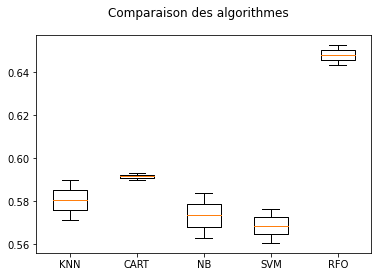

In [38]:
fig = plt.figure()
fig.suptitle('Comparaison des algorithmes')
ax = fig.add_subplot(111)
plt.boxplot(res)
ax.set_xticklabels(names)

On a decider d'utiliser le "RandomForestClassifier" car il donne des meilleures resultats par rapport aux autres classifieurs

## Grid Search (recherche des meilleurs paramétres)

### a.Dowsampling

In [52]:
rfc = RandomForestClassifier(random_state=42)

param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [58]:
#display(downsampled)
X = downsampled.drop('truthRating', axis=1)
#display(X)
#display(downsampled)

y = downsampled['truthRating']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [59]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(x_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                  

In [60]:
CV_rfc.best_params_

{'criterion': 'entropy',
 'max_depth': 7,
 'max_features': 'auto',
 'n_estimators': 500}

In [76]:
rfc1=RandomForestClassifier(random_state=42, max_features='auto', n_estimators= 500, max_depth=7, criterion='entropy')

In [77]:
#print(rfc1)
rfc1.fit(x_train, y_train)

pred=rfc1.predict(x_test)

In [78]:
print("Accuracy for Random Forest on Downsampling: ",accuracy_score(y_test,pred))

Accuracy for Random Forest on CV data:  0.645293315143247


## Upsampling

In [73]:
X = upsampled.drop('truthRating', axis=1)
#display(X)
#display(downsampled)

y = upsampled['truthRating']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(x_train, y_train)


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                  

In [74]:
CV_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'log2',
 'n_estimators': 500}

In [81]:
rfc2=RandomForestClassifier(random_state=42, max_features='log2', n_estimators= 500, max_depth=8, criterion='gini')

In [82]:
rfc2.fit(x_train, y_train)

pred=rfc2.predict(x_test)

In [83]:
print("Accuracy for Random Forest on Upsampling: ",accuracy_score(y_test,pred))

Accuracy for Random Forest on CV data:  0.7025920873124147


## V Analyse

### Recherche des features discriminantes

In [95]:
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

KB = SelectKBest(chi2, k=1)
X_new = KB.fit_transform(X, y)
X_new.shape

column_name = X.columns[KB.get_support()]
display(column_name)

Index(['timestamp'], dtype='object')

Conclusion: la variable est la date

In [102]:
KB_plus = SelectKBest(chi2, k=50)
X_new = KB_plus.fit_transform(X, y)
X_new.shape

column_name_plus = X.columns[KB_plus.get_support()]
display(column_name_plus)

Index(['almost', 'announce', 'arrest', 'dead', 'every', 'find', 'georgia',
       'iraq', 'less', 'muslim', 'percent', 'spend', 'state', 'worth',
       'author_Andrew Cuomo', 'author_Barack Obama', 'author_Bernie Sanders',
       'author_Beto O'Rourke', 'author_Bill White', 'author_Bloggers',
       'author_Chain email', 'author_Charlie Crist', 'author_Chris Christie',
       'author_Dennis Kucinich', 'author_Donald Trump',
       'author_Facebook posts', 'author_Hemant Mehta',
       'author_Hillary Clinton', 'author_Jeb Bush', 'author_Joe Manchin',
       'author_John Boehner', 'author_John Kasich', 'author_Lloyd Doggett',
       'author_Mahlon Mitchell', 'author_Mark Pocan',
       'author_Michele Bachmann', 'author_Nathan Deal', 'author_Paul Krugman',
       'author_Rachel Maddow', 'author_Rob Portman', 'author_Rush Limbaugh',
       'author_Sherrod Brown', 'author_Tim Kaine', 'author_Unknown',
       'author_Viral image', 'author_Yvette McGee Brown', 'timestamp',
       'source_p

## IV.a. Deuxiéme tâche de classification : {VRAI et FAUX} vs {MIXTURE}

In [106]:
def replace_false(value):
    if value == 3:
        return 1
    return value

df_task2 = df_features.copy()
df_task2['truthRating'] = df_task2['truthRating'].apply(replace_false)

g=df_task2.groupby(['truthRating'])
print(g['id'].count())

truthRating
1    4992
2    3247
Name: id, dtype: int64


### Upsampling

In [107]:
true_false_rows = df_task2[df_task2.truthRating==1]
mixture_rows = df_task2[df_task2.truthRating==2]

mixture_upsampled = resample(mixture_rows, replace=True, n_samples=len(true_false_rows), random_state=27)
display(true_false_rows)
display(mixture_rows)
upsampled_task2 = pd.concat([true_false_rows, mixture_upsampled])
upsampled_task2.sort_index(inplace=True)
upsampled_task2 = upsampled_task2.reset_index(drop=True)

print("upsampled shape")
display(upsampled_task2.shape)
g=upsampled_task2.groupby(['truthRating'])
print(g['id'].count())
display(df_task2.shape)

,aaa,aaron,ab,aba,abaco,abandon,abbey,abbott,abbreviation,abby,...,author_tmzbreaking,author_world-newss.com,author_worldnewsdailyreport.com,timestamp,source_africacheck,source_factscan,source_politifact,source_snopes,source_truthorfiction,truthRating
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1.395176e+09,0,0,0,1,0,1
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1.299020e+09,0,0,1,0,0,1
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1.395176e+09,0,0,0,1,0,1
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1.443305e+09,0,0,1,0,0,1
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1.365458e+09,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8230,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1.395176e+09,0,0,0,1,0,1
8231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1.395176e+09,0,0,0,1,0,1
8233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1.395176e+09,0,0,0,1,0,1
8235,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1.291072e+09,0,0,1,0,0,1


,aaa,aaron,ab,aba,abaco,abandon,abbey,abbott,abbreviation,abby,...,author_tmzbreaking,author_world-newss.com,author_worldnewsdailyreport.com,timestamp,source_africacheck,source_factscan,source_politifact,source_snopes,source_truthorfiction,truthRating
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1.329260e+09,0,0,1,0,0,2
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1.252966e+09,0,0,1,0,0,2
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1.395176e+09,0,0,0,1,0,2
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1.245017e+09,0,0,1,0,0,2
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1.338761e+09,0,0,1,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8229,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1.421104e+09,0,0,1,0,0,2
8232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1.302386e+09,0,0,1,0,0,2
8234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1.219615e+09,0,0,1,0,0,2
8237,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1.395176e+09,0,0,0,1,0,2


upsampled shape


(9984, 12517)

truthRating
1    4992
2    4992
Name: id, dtype: int64


(8239, 12517)

In [ ]:
display(upsampled_task2)

df_val = upsampled_task2.values

res, names = k_fold_multi_classifier(df_val)

,aaa,aaron,ab,aba,abaco,abandon,abbey,abbott,abbreviation,abby,...,author_tmzbreaking,author_world-newss.com,author_worldnewsdailyreport.com,timestamp,source_africacheck,source_factscan,source_politifact,source_snopes,source_truthorfiction,truthRating
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1.395176e+09,0,0,0,1,0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1.245017e+09,0,0,1,0,0,2
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1.245017e+09,0,0,1,0,0,2
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1.245017e+09,0,0,1,0,0,2
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1.299020e+09,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9979,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1.395176e+09,0,0,0,1,0,2
9980,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1.395176e+09,0,0,0,1,0,2
9981,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1.395176e+09,0,0,0,1,0,2
9982,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1.395176e+09,0,0,0,1,0,2


array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

array([1., 2., 2., ..., 2., 2., 2.])

KNN: 0.606268 (0.014834)
CART: 0.613983 (0.015560)
NB: 0.574824 (0.024587)
